## Code to embed 100,000 FSPS model spectra with zcontinuous=1 and diverse SFHs and look for meaningful dimensions in the embeddings

Authored by OGT 17-06-21; updated 17-10-27

In [130]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.pairwise import euclidean_distances

np.set_printoptions(suppress=True)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick.major', width=2)
mpl.rc('ytick.major', width=2)
mpl.rc('axes', labelsize=18, linewidth=2, titlesize=18)
mpl.rc('figure', titlesize=18)
mpl.rc('lines', linewidth=3)
mpl.rc('legend', fontsize=16)

In [2]:
# load data

f = h5py.File('../data/1e5_spectra_diverseSFH_17-02-07.hdf5','r')
spectra = f['spectra'][:]
wave = f['wave'][:]
taus = f['taus'][:]
mean_ages = f['mean_ages'][:]
zs = f['zs'][:]
dusts = f['dusts'][:]
sdss_mags = f['sdss_mags'][:]
fbursts = f['fbursts'][:]
tbursts = f['tbursts'][:]
sf_begins = f['sf_begins'][:]
f.close()

In [3]:
# copy some plotting code to make life easier

def make_cc_plot(embed, color, label, dims=[[0,1],[2,1]], axlim=None):
    # axlim is a list of [min,max] for dim0, dim2, dim1 (left x, right x, mutual y axes)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,dims[0][0]], embed[:,dims[0][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim'+str(dims[0][0]))
    ax[0].set_ylabel('dim'+str(dims[0][1]))

    b = ax[1].scatter(embed[:,dims[1][0]], embed[:,dims[1][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim'+str(dims[1][0]))
    ax[1].set_ylabel('dim'+str(dims[1][1]))
    
    if axlim is not None:
        ax[0].set_xlim(axlim[0])
        ax[0].set_ylim(axlim[2])
        ax[1].set_xlim(axlim[1])
        ax[1].set_ylim(axlim[2])
        
    plt.tight_layout()
    return fig, ax

In [4]:
# do a dense distance matrix for a 10,000 spectrum subset of the data to determine dimensionality, radius
# code taken from NvsR.ipynb

distmatrix = euclidean_distances(spectra[:10000,:])

ns = []
rs = np.logspace(-1.5,1.5,300)

for r in rs:
    test = distmatrix <= r
    neighbors = np.sum(test, axis=0) 
    ns.append(np.mean(neighbors) - 1.)  # account for one 0 per row (erronious neighbor)

In [5]:
logr = np.log10(rs)
logn = np.log10(ns)
wh = logr < 0.2

In [6]:
# fit a quick line to linear part -- dimensionality
from scipy.optimize import curve_fit

def f(x, A, B):
    return A*x + B

A, B = curve_fit(f, logr[wh], logn[wh])[0]
print A

3.03457661723


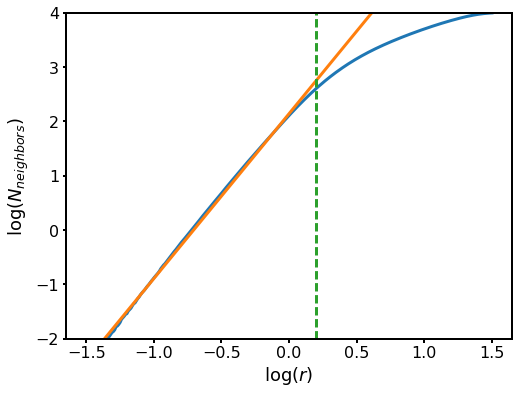

In [47]:
plt.figure(figsize=(8,6));
plt.plot(logr, logn);
plt.xlabel(r'$\log(r)$');
plt.ylabel(r'$\log(N_{neighbors})$');
plt.plot(logr, f(logr, A, B));
plt.plot([0.2,0.2],[-2,4],'--');
plt.ylim(-2,4);

#### OK, want to choose log(r) such that log(n) is roughly 3, because we need 30 neighbors at the cutoff in the full sample (10x larger). And we want to choose a slightly larger log(r) because the kernel width is r/3. So let's choose the radius where we have 9 neighbors.

Update -- this radius was too small; no information captured in embedding. Trying again with just the 10,000 spectrum subsample and the radius where we have 60 neighbors.

In [9]:
idx = (np.abs(logn - np.log10(60))).argmin()
logn[idx], logr[idx]

(1.7920413107120823, -0.1153846153846154)

### Now, we do the embedding with this "optimal" radius... 

In [10]:
radius = 10**-0.1
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)
print new_radius

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=6, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

0.794328


/astro/users/otelford/.local/lib/python2.7/site-packages/megaman/embedding/spectral_embedding.py:161: UserWarning: Graph is not fully connected: spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected: "


In [11]:
# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

129 components
9835 spectra in first component


### OK, now let's look for some sort of sensible structure in the largest, first component only. First, make projections using all 6 dimensions color-coding by age (since this seems to be the variable that is most correlated with some of the dimensions)

(<matplotlib.figure.Figure at 0x7f2bbf30b8d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbec85c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbec5dd50>], dtype=object))

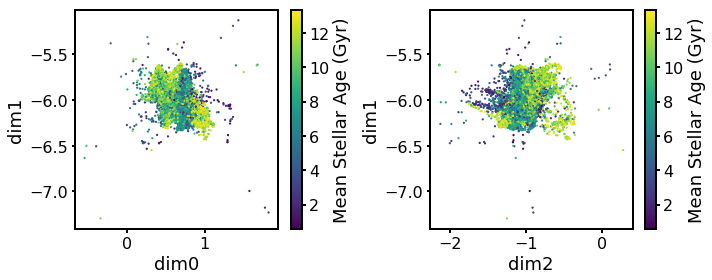

In [48]:
# plot some dimensions against each other color coded by a param of interest
wh = labels == 0
use_embed = embed[wh,:] * 1000
make_cc_plot(use_embed, mean_ages[:10000][wh], 'Mean Stellar Age (Gyr)', dims=[[0,1],[2,1]])

(<matplotlib.figure.Figure at 0x7f2bbeaa0d10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbea5e210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbe9cbad0>], dtype=object))

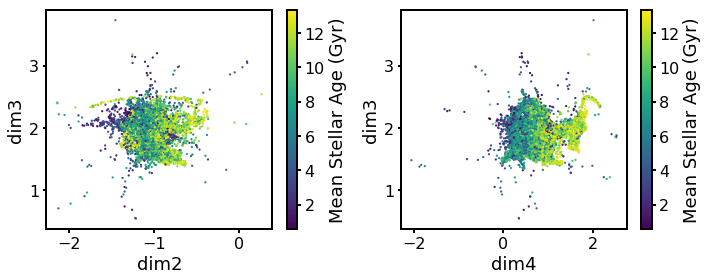

In [49]:
# plot some dimensions against each other color coded by a param of interest
wh = labels == 0
use_embed = embed[wh,:] * 1000
make_cc_plot(use_embed, mean_ages[:10000][wh], 'Mean Stellar Age (Gyr)', dims=[[2,3],[4,3]])

(<matplotlib.figure.Figure at 0x7f2bbe803ed0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbe7c0150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbe7bd290>], dtype=object))

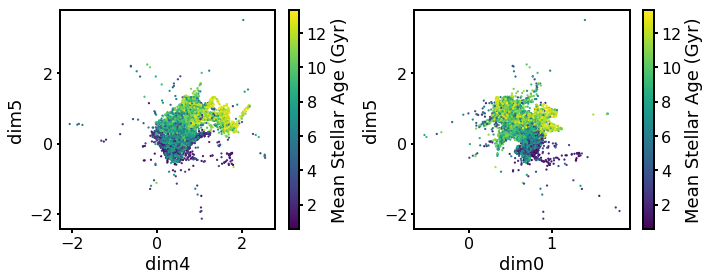

In [50]:
# plot some dimensions against each other color coded by a param of interest
wh = labels == 0
use_embed = embed[wh,:] * 1000
make_cc_plot(use_embed, mean_ages[:10000][wh], 'Mean Stellar Age (Gyr)', dims=[[4,5],[0,5]])

### Now projections along the first few dimensions color-coding by metallicity and dust

(<matplotlib.figure.Figure at 0x7f2bbed56cd0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbee9e810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbfabc290>], dtype=object))

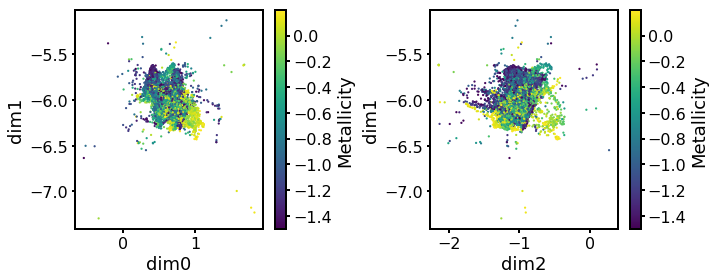

In [51]:
make_cc_plot(use_embed, zs[:10000][wh], 'Metallicity', dims=[[0,1],[2,1]])

(<matplotlib.figure.Figure at 0x7f2bbee61e10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbfd4f650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2bbf18c350>], dtype=object))

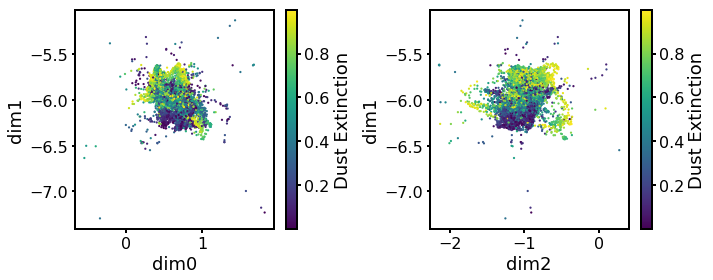

In [52]:
make_cc_plot(use_embed, dusts[:10000][wh], 'Dust Extinction', dims=[[0,1],[2,1]])

### Now, try plotting each parameter (age, metallicity, dust) vs. all 6 dimensions, and color-code by each of the other two parameters to look for any multi-dimensional relationships...

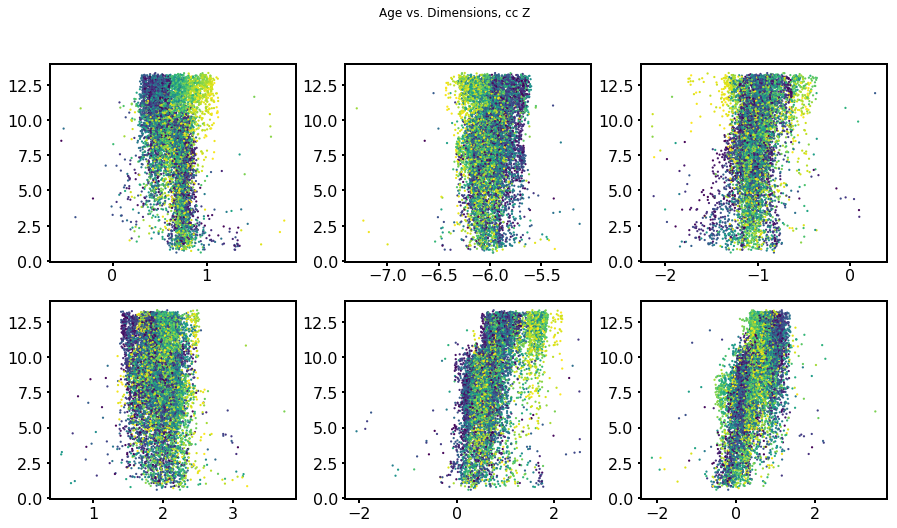

In [53]:
# plot all of the parameters of interest vs. all dimensions in the embedding, color-code by other params... 
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=zs[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Age vs. Dimensions, cc Z')

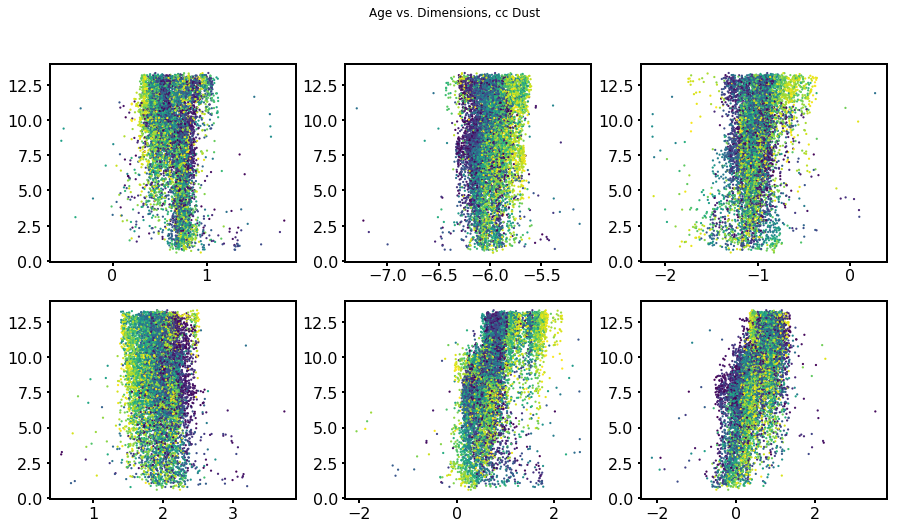

In [54]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=dusts[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Age vs. Dimensions, cc Dust')

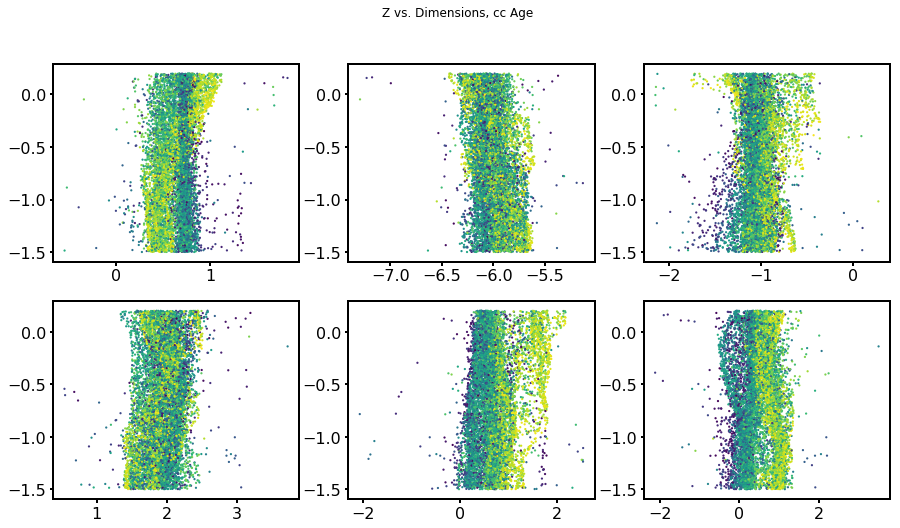

In [55]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], zs[:10000][wh], c=mean_ages[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Z vs. Dimensions, cc Age')

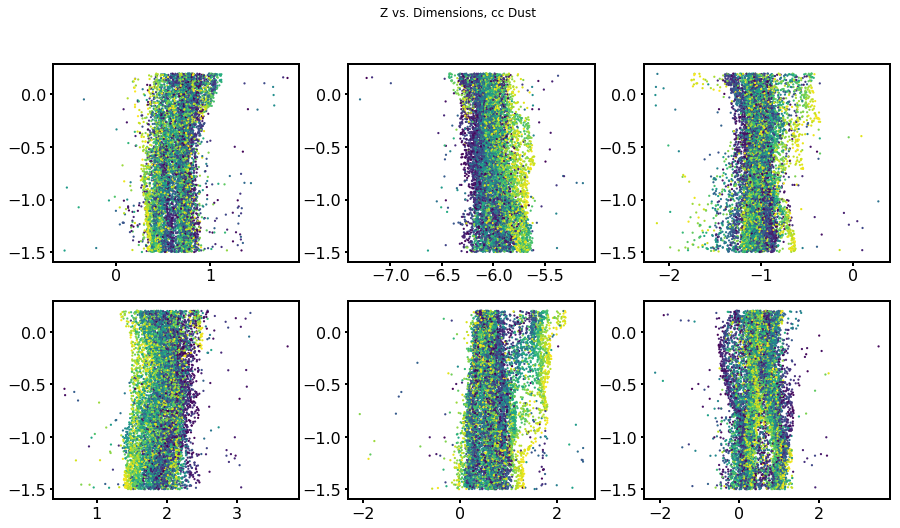

In [56]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], zs[:10000][wh], c=dusts[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Z vs. Dimensions, cc Dust')

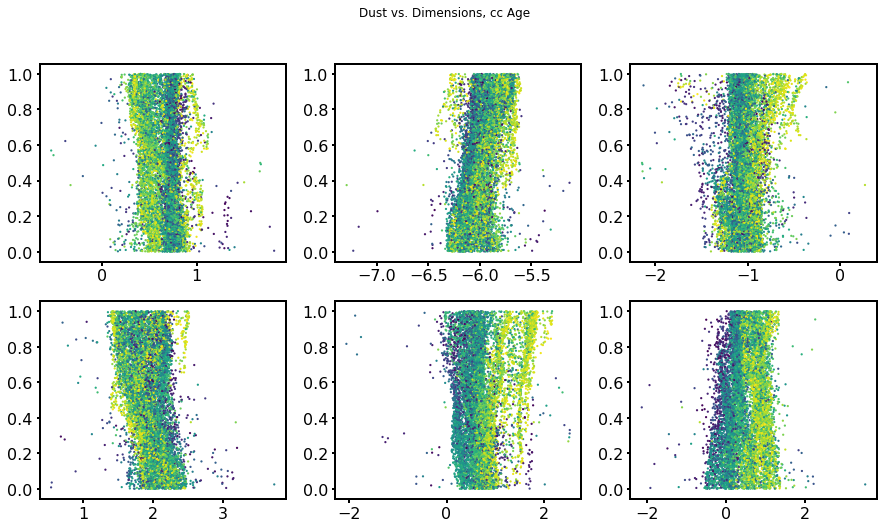

In [57]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], dusts[:10000][wh], c=mean_ages[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Dust vs. Dimensions, cc Age')

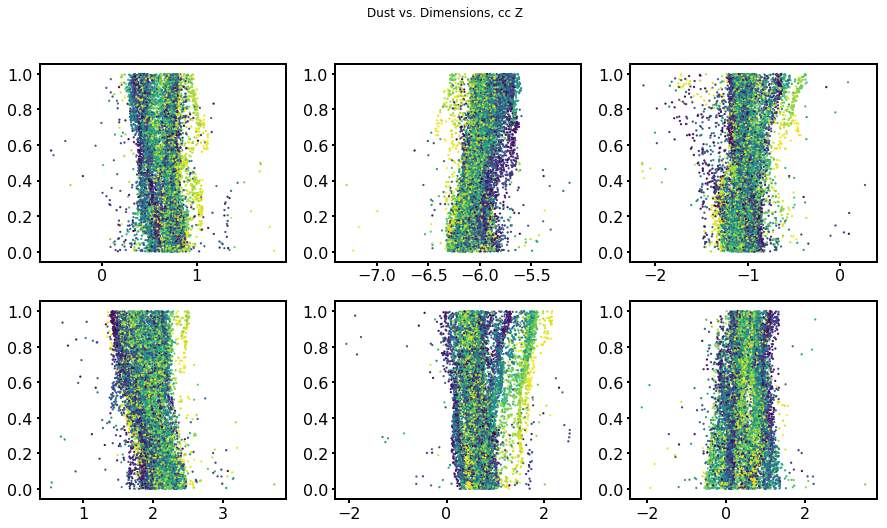

In [58]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], dusts[:10000][wh], c=zs[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Dust vs. Dimensions, cc Z')

### OK, this is progress! The first time these plots look remotely informative is when you plot/color code by two age parameters! Interesting. Color coding by burst fraction doesn't look informative at all though.

Do these just look more sensible because the mean stellar age is highly correlated with the burst time and exponential decay timescale? I have lost track of whether this is useful...

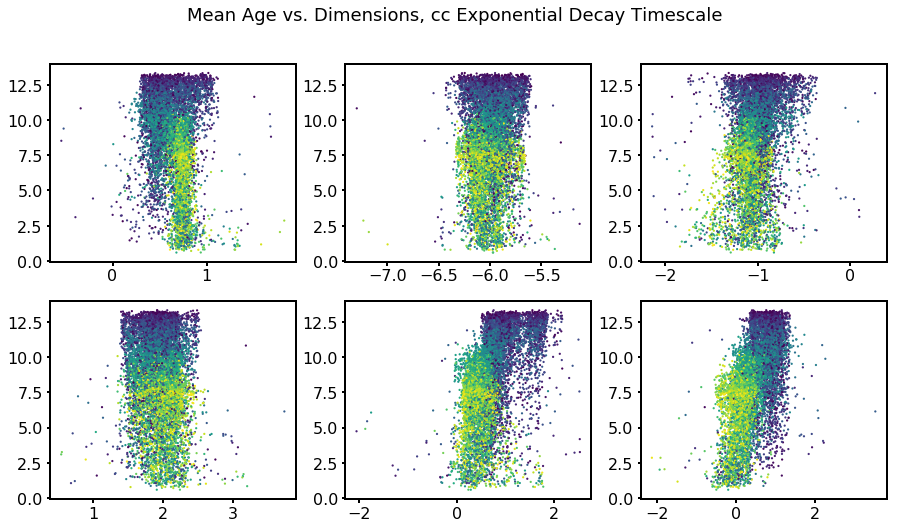

In [136]:
# try looking at the detailed SFH parameters
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=np.log10(taus[:10000][wh]), s=5, lw=0, cmap='viridis')
fig.suptitle('Mean Age vs. Dimensions, cc Exponential Decay Timescale')

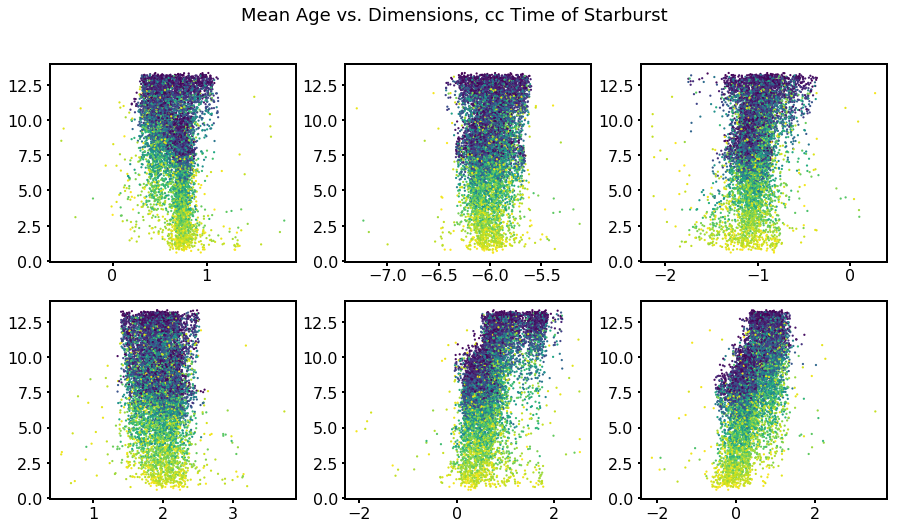

In [139]:
# try looking at the detailed SFH parameters
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=tbursts[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Mean Age vs. Dimensions, cc Time of Starburst')

## Examples of spectra with varying values for mean stellar age, metallicity, and dust

In [99]:
start_index = np.argmin(np.abs(mean_ages - 5.0))
fixdust = dusts[start_index]
fixz = zs[start_index]
tol = 0.01
inds = (np.abs(dusts - fixdust) < tol)*(np.abs(zs - fixz) < tol)
print mean_ages[inds]
use_spec = spectra[inds][[0, 2]]
use_ages = mean_ages[inds][[0, 2]]
print zs[inds][[0, 2]], dusts[inds][[0, 2]]

[  8.77024847   5.01122642  12.76439476   9.64534358   8.79582918
   2.14624704   5.00001142  11.51919007   6.4353384    5.42006981
   9.42485224  11.82409884   9.93390073  13.22547307   7.92543926
   5.62414836   4.41138553   3.90021653   9.49568473   8.14795726
  11.96393447  10.58700138   7.79883668   5.56838734  11.22509184
   1.51532142   4.77550853  12.12173752]
[-0.74281997 -0.74475784] [ 0.09000765  0.08935136]


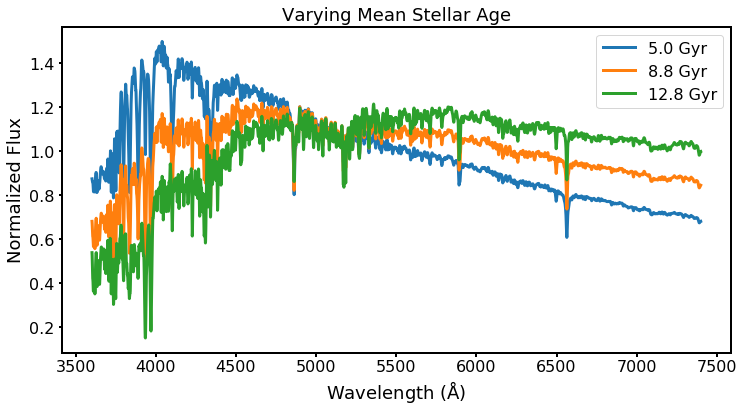

In [100]:
plt.figure(figsize=(12,6))
plt.plot(wave, spectra[start_index], label='%.1f Gyr' % mean_ages[start_index])
plt.plot(wave, use_spec[0], label='%.1f Gyr' % use_ages[0])
plt.plot(wave, use_spec[1], label='%.1f Gyr' % use_ages[1])
plt.legend()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.title('Varying Mean Stellar Age')

### OK, this is actually a great example of how different star formation history can make a big difference! Mean stellar age is generally well-correlated with the overall spectral shape, but here, one of these galaxies has a very old SFH with a fairly large burst of star formation a little after the bulk of the stars formed. So its mean stellar age becomes younger than its spectrum would make you think!

In [123]:
start_index = np.argmin(np.abs(zs + 1.0))
fixdust = dusts[start_index]
fixage = mean_ages[start_index]
print fbursts[start_index], tbursts[start_index], taus[start_index]
tol = 0.03
inds = (np.abs(dusts - fixdust) < tol)*(np.abs(mean_ages - fixage) < tol)
print zs[inds]
use_spec = spectra[inds][[5, 3]]
use_zs = zs[inds][[5, 3]]
print mean_ages[inds][[5, 3]], dusts[inds][[5, 3]], fbursts[inds][[5, 3]], tbursts[inds][[5, 3]], taus[inds][[5, 3]]

0.0533670248373 2.91810107892 4.39684256784
[ 0.03991737 -1.35486435 -0.16717864  0.11848582 -0.13593933 -0.36806096
 -0.44512384 -0.99998337 -0.16685083  0.16179463 -1.21049074 -1.35578097
 -0.23628709 -0.77922953 -0.88086307 -0.70175756 -0.24928414 -0.09942101
 -1.31080494  0.07782636  0.16843793 -0.64183241 -1.11650903 -1.41790994
 -0.9866924  -1.20226435 -1.30474615  0.10818375 -1.13993329]
[ 9.70961971  9.70301798] [ 0.02127866  0.01388792] [ 0.1381037   0.03641019] [ 2.92452351  1.62000497] [ 1.25541509  4.02757086]


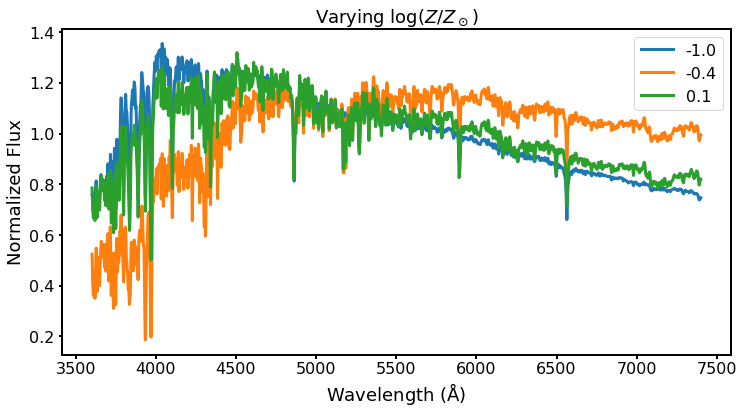

In [119]:
plt.figure(figsize=(12,6))
plt.plot(wave, spectra[start_index], label='%.1f' % zs[start_index])
plt.plot(wave, use_spec[0], label='%.1f' % use_zs[0])
plt.plot(wave, use_spec[1], label='%.1f' % use_zs[1])
plt.legend()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.title(r'Varying Metallicity')

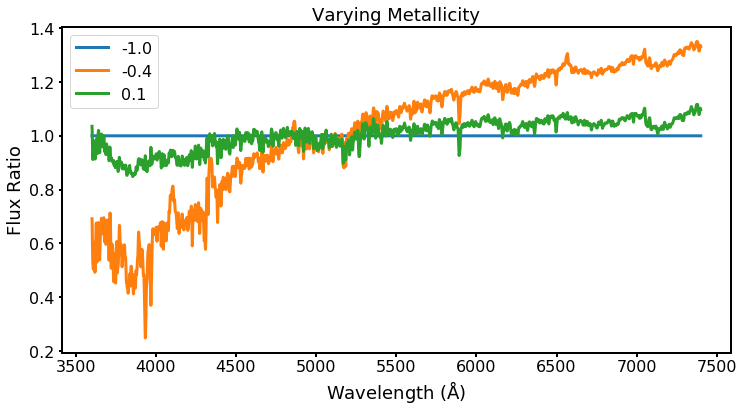

In [121]:
plt.figure(figsize=(12,6))
plt.plot(wave, spectra[start_index]/spectra[start_index], label='%.1f' % zs[start_index])
plt.plot(wave, use_spec[0]/spectra[start_index], label='%.1f' % use_zs[0])
plt.plot(wave, use_spec[1]/spectra[start_index], label='%.1f' % use_zs[1])
plt.legend()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux Ratio')
plt.title(r'Varying Metallicity')

In [114]:
start_index = np.argmin(np.abs(dusts))
fixz = zs[start_index]
fixage = mean_ages[start_index]
tol = 0.03
inds = (np.abs(zs - fixz) < tol)*(np.abs(mean_ages - fixage) < tol)
print fixz, fixage
print dusts[inds]
use_spec = spectra[inds][[3, 5]]
use_dusts = dusts[inds][[3, 5]]
print mean_ages[inds][[3, 5]], zs[inds][[3, 5]], fbursts[inds][[3, 5]], tbursts[inds][[3, 5]]

0.104071099847 6.8252167687
[ 0.65382828  0.19620139  0.76718037  0.52966694  0.00001196  0.93805822
  0.77901931  0.41753032  0.19469739  0.32392765  0.68862692  0.00916872
  0.5892095   0.46065351  0.21798522  0.214812    0.54432118  0.83701957
  0.48837481  0.1724358   0.81673703]
[ 6.82681811  6.79950782] [ 0.09505942  0.0770787 ] [ 0.13910216  0.03967965] [ 6.23547261  6.51980919]


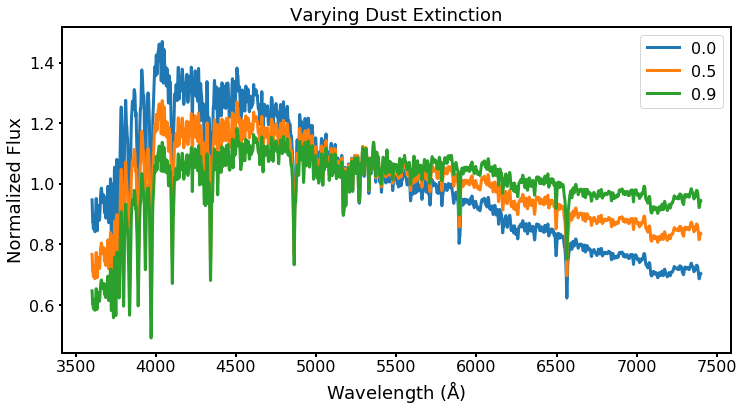

In [115]:
plt.figure(figsize=(12,6))
plt.plot(wave, spectra[start_index], label='%.1f' % dusts[start_index])
plt.plot(wave, use_spec[0], label='%.1f' % use_dusts[0])
plt.plot(wave, use_spec[1], label='%.1f' % use_dusts[1])
plt.legend()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.title(r'Varying Dust Extinction')

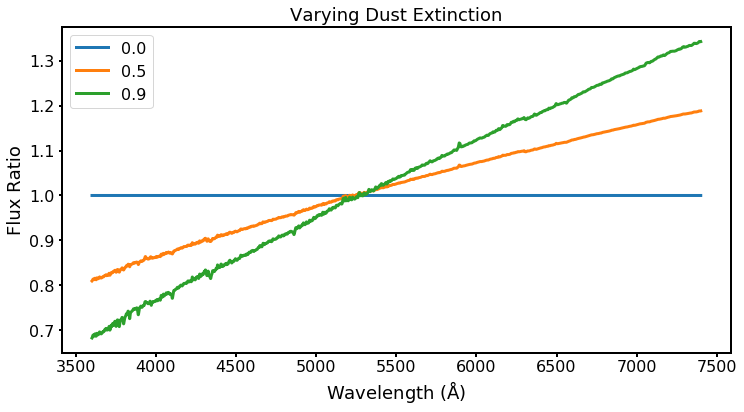

In [117]:
plt.figure(figsize=(12,6))
plt.plot(wave, spectra[start_index]/spectra[start_index], label='%.1f' % dusts[start_index])
plt.plot(wave, use_spec[0]/spectra[start_index], label='%.1f' % use_dusts[0])
plt.plot(wave, use_spec[1]/spectra[start_index], label='%.1f' % use_dusts[1])
plt.legend()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux Ratio')
plt.title(r'Varying Dust Extinction')